# Test Basic

In [1]:
using AutomotiveDrivingModels
using AutoScenes
using AutoViz
using Base.Test

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.4/AutoScenes.ji for module AutoScenes.


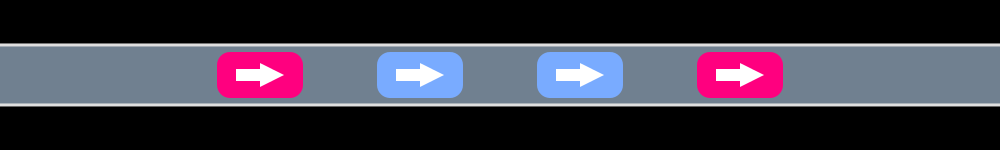

In [2]:
roadway = gen_straight_roadway(1)
scene = Scene([
    Vehicle(VehicleState(VecSE2(100.0,0.0,0.0), roadway, 1.0), VehicleDef(1, AgentClass.CAR, 4.0, 2.0)),
    Vehicle(VehicleState(VecSE2(108.0,0.0,0.0), roadway, 2.0), VehicleDef(2, AgentClass.CAR, 4.0, 2.0)),
    Vehicle(VehicleState(VecSE2(116.0,0.0,0.0), roadway, 0.0), VehicleDef(3, AgentClass.CAR, 4.0, 2.0)),
    Vehicle(VehicleState(VecSE2( 92.0,0.0,0.0), roadway, 0.0), VehicleDef(4, AgentClass.CAR, 4.0, 2.0)),
])
special_car_colors = Dict{Int,Colorant}()
special_car_colors[1] = COLOR_CAR_EGO
special_car_colors[2] = COLOR_CAR_EGO
render(scene, roadway, cam=SceneFollowCamera(20.0), canvas_height=150, special_car_colors=special_car_colors)

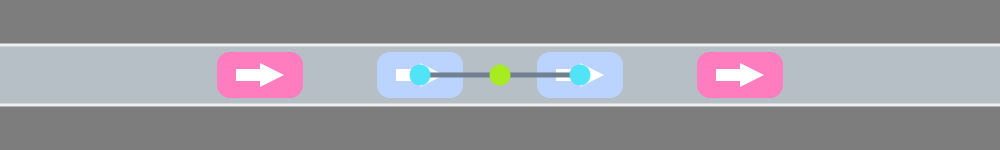

In [3]:
structure = SceneStructure([
    FactorAssignment(FeatureForms.ROAD, [1]),
    FactorAssignment(FeatureForms.ROAD, [2]),
    FactorAssignment(FeatureForms.FOLLOW, [1,2]),
    ], Set{Int}([1,2]), LeadFollowRelationships([2,3,0,1], [4,1,2,0]))
overlays = SceneOverlay[Overwash(RGBA(1.0,1.0,1.0,0.7)), SceneStructureOverlay(structure)]
render(scene, roadway, overlays, cam=SceneFollowCamera(20.0), canvas_height=150, special_car_colors=special_car_colors)

In [4]:
vehdefs = Dict{Int, VehicleDef}()
vehdefs[1] = scene[1].def
vehdefs[2] = scene[2].def
vehdefs[3] = scene[3].def
vehdefs[4] = scene[4].def

states = [TrajdataState(1, scene[1].state),
          TrajdataState(2, scene[2].state),
          TrajdataState(3, scene[3].state),
          TrajdataState(4, scene[4].state),
]

frames = [TrajdataFrame(1,4,0.0)]

dset = SceneStructureDataset(
    [Trajdata(roadway, vehdefs, states, frames)],
    [AutoScenes.SceneSource(1, 1)],
    [structure],
    create_shared_factors(),
)

length(dset)

1

In [5]:
ϕ_road = dset.factors[1] # shared factor
vehicle_indeces = [1]
extract!(ϕ_road, scene, roadway, vehicle_indeces)
@test ϕ_road.template.values == [1.0]
@test evaluate(ϕ_road.template, ϕ_road.instances[1]) == 1.0
@test evaluate(ϕ_road.template, ϕ_road.instances[2]) == 1.0^2
@test evaluate_dot(ϕ_road) == 1.1

In [6]:
vehicle_indeces = [2]
extract!(ϕ_road, scene, roadway, vehicle_indeces)
@test ϕ_road.template.values == [2.0]
@test evaluate(ϕ_road.template, ϕ_road.instances[1]) == 2.0
@test evaluate(ϕ_road.template, ϕ_road.instances[2]) == 2.0^2
@test evaluate_dot(ϕ_road) == 2.4

In [7]:
ϕ_follow = dset.factors[2] # shared factor
vehicle_indeces = [1,2]
extract!(ϕ_follow, scene, roadway, vehicle_indeces)
@test ϕ_follow.template.values == [1.0]
@test evaluate(ϕ_follow.template, ϕ_follow.instances[1]) == 1.0
@test evaluate_dot(ϕ_follow) == 1.0

In [8]:
@test evaluate_dot!(structure, dset.factors, scene, roadway, SceneRecord(1,0.1)) == 4.5

In [10]:
plog = calc_pseudolikelihood(dset, dat = PseudolikelihoodPrealloc(100000))
@test isapprox(plog, 0.1184, atol=0.001)

In [12]:
grad = calc_pseudolikelihood_gradient(FeatureForms.ROAD, 1, dset, 1, 100000, 0.0)
@test isapprox(grad, 0.35208, atol=0.005)